### Importing libraries and Dataset

In [1]:
import numpy as np 
import pandas as pd 	
import matplotlib.pyplot as plt 
import math
import seaborn as sns

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide            Covid Cases and Deaths WorldWide                     8KB  2023-02-01 12:22:51           3382         87  1.0              
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                         480KB  2023-01-04 12:50:31          12392        391  1.0              
datascientistanna/customers-dataset                             Shop Customer Data                                  23KB  2023-02-07 18:42:21           2453         69  1.0              
themrityunjaypathak/most-subscr

In [3]:
! kaggle datasets download -d merishnasuwal/breast-cancer-prediction-dataset

  0% 0.00/7.92k [00:00<?, ?B/s]
100% 7.92k/7.92k [00:00<00:00, 6.07MB/s]


In [4]:
! unzip breast-cancer-prediction-dataset.zip

Archive:  breast-cancer-prediction-dataset.zip
  inflating: Breast_cancer_data.csv  


In [15]:
data = pd.read_csv("Breast_cancer_data.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


## Data Analysis

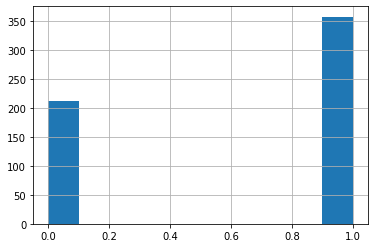

In [16]:
data["diagnosis"].hist()

The following steps tells us which columns are independent an which are not.

Since for naive bayes classifier needs independent variables, we chose one of the dependent.

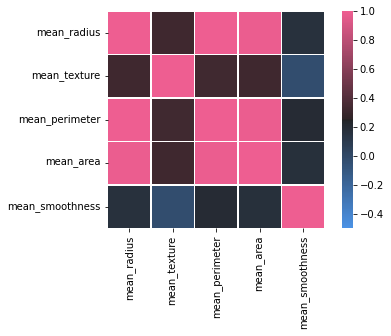

In [17]:
corr = data.iloc[:,:-1].corr(method="pearson")

cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [27]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


To deal with continuous variables, we need to fit a known distribution (Normal Distribution. And for that we first need to check if they even mimic the known diastribution.

If they do, we fit.

If they don't, they won't make up to a good result.

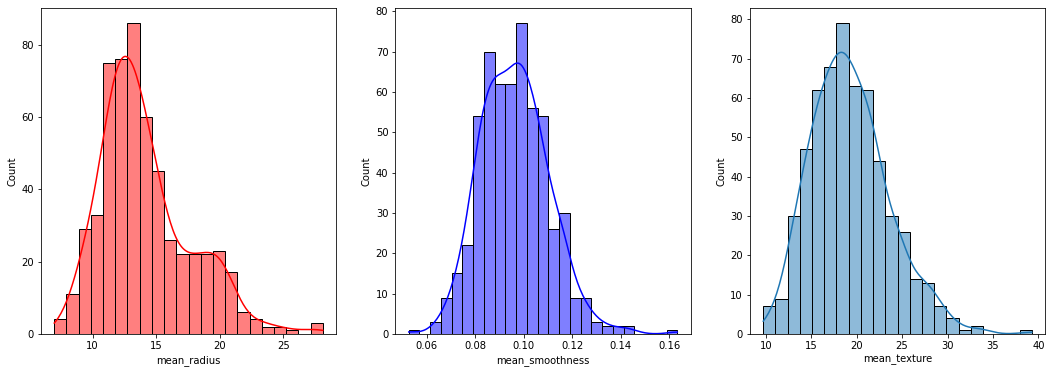

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

We can see that the second and third plots look very similar to the normal distribution.

As for the first plot, The mean distribution varies a little, but isn't far off to discard, so we will fit the normal distribution here as well.

## The actual Code

We will be computing likelihood and prior probabilities to finally calculate posterior probability.

### Calculating prior probability

In [29]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

### Calculating likelihood

#### By Gaussian Distribution

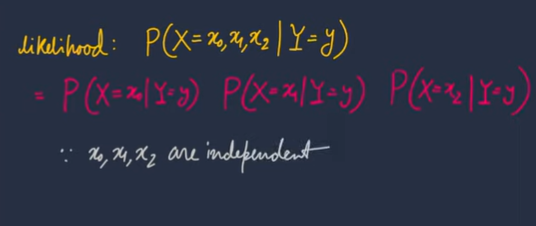

In [30]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

### Naive Bayes Classifier

In [31]:
def naive_bayes_gaussian(df, X, Y):

    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []

    # loop over every data sample
    for x in X:
      
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

### Testing out Gaussian Model

In [32]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

In [33]:
X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values

In [34]:
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

In [35]:
from sklearn.metrics import confusion_matrix, f1_score

In [36]:
print(confusion_matrix(Y_test, Y_pred))

[[36  4]
 [ 0 74]]


In [37]:
print(f1_score(Y_test, Y_pred))

0.9736842105263158
